In [1]:
import glob, sys
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

In [2]:
sys.path.append("..")
sam = sam_model_registry["vit_h"](checkpoint="checkpoints/sam_vit_h_4b8939.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
sam.to(device)
predictor = SamPredictor(sam)
predictor

# 1-Data preparation

In [14]:
def yolo2cv(bbox): 
    # In function calls, the asterisk (*) can be used to unpack a list or tuple into individual arguments
    #Bu yerda list comprehensiondan chiqqan 4 ta qiymatni x, y, w, h argument sifatida jonatyapti.
    return get_coordinates(*[float(bb) for bb in bbox.split(" ")[1:]])


def get_coordinates(x, y, w, h):
    """ This function formula converts [0, 1] range YOLO format to OpenCV format"""
    return [int((x - (w / 2)) * 1200), 
            int((y - (h / 2)) * 1200), 
            int((x + (w / 2)) * 1200), 
            int((y + (h / 2)) * 1200)]

def segment_image(image, input_boxes):
    predictor.set_image(image)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,)
    return masks 

segmented_data = []
for i, img_path in enumerate(tqdm.tqdm(glob.glob("furniture dataset/images/*"))): 
    #if i == 10:  break
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img.shape[0], img.shape[1]
    bbox_path = img_path.replace('images', 'labels').replace(".jpg", ".txt")
    bboxes = open(bbox_path, mode='r').read().split("\n") #rasmdagi har bir obyektni bboxini nextline boyicha olish
    
    if len(bboxes) < 1: continue #rasmda object umuman yoq holatda   
    #har bir boxga kiradi va yolo2cv2 funksiyasini chaqirib -> u esa har bir box x,y,w,h cordinatani olib opencv formatga formula orqali o'tkazadi otkazadi va qaytaradi
    bbox_coordinates = []
    for bbox in bboxes: 
        bbox_coordinates.append(yolo2cv(bbox))

    input_boxes = torch.tensor(bbox_coordinates, device = predictor.device)
    masks = segment_image(image=img, input_boxes = input_boxes)
    segmented_data.append((img, masks))

  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 161/161 [07:53<00:00,  2.94s/it]


In [15]:
len(segmented_data)

161

# 2 - Predict segmenatation

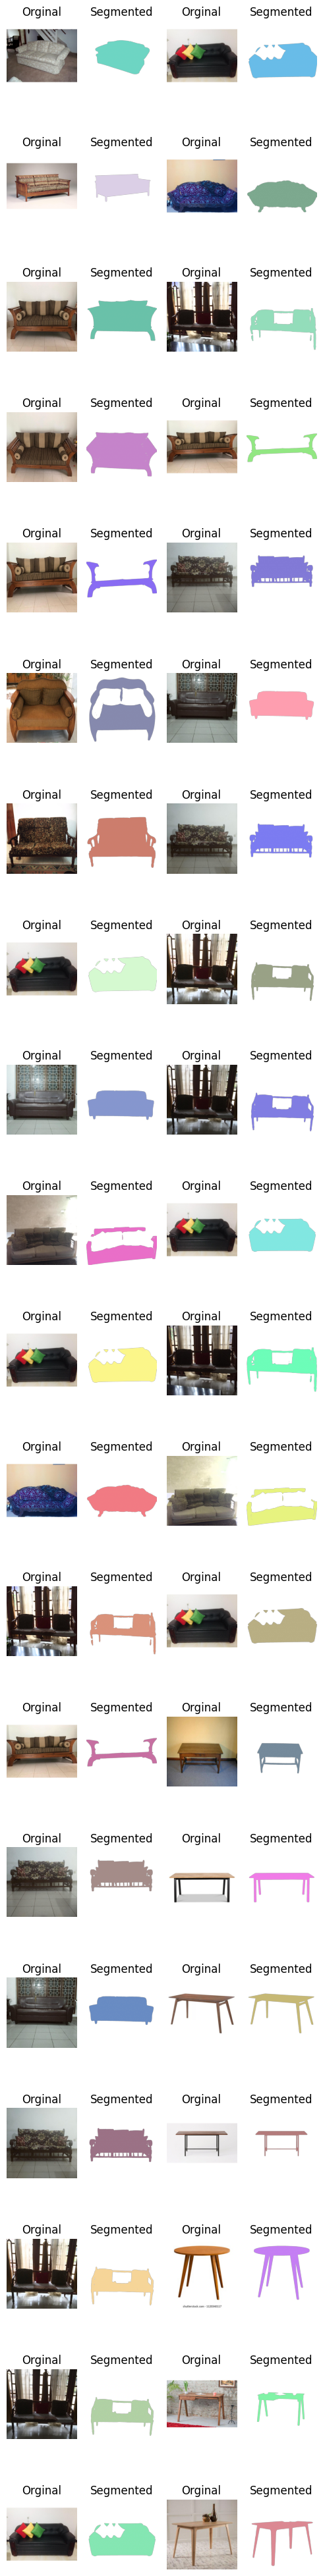

In [16]:
import numpy as np 
import random

def mask2img(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image


rand_indexes = [random.randint(0, len(segmented_data)) for _ in range(20)]
fig, axes = plt.subplots(len(rand_indexes), 4, figsize=(5, len(rand_indexes)*2)) 
# Loop through image and labels and plot
for i, idx in enumerate(rand_indexes):
    img, masks = segmented_data[i]
    img_mask = mask2img(masks.cpu().numpy(), plt.gca(), random_color=True)
    img2, masks2 = segmented_data[i+10]
    img_mask2 = mask2img(masks2.cpu().numpy(), plt.gca(), random_color=True)

    axes[i, 0].imshow(img)
    axes[i, 1].imshow(img_mask)
    axes[i, 2].imshow(img2)
    axes[i, 3].imshow(img_mask2)
    axes[i, 0].set_title(f"Orginal")
    axes[i, 1].set_title(f"Segmented")
    axes[i, 2].set_title(f"Orginal")
    axes[i, 3].set_title(f"Segmented")
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 3].axis('off')
plt.tight_layout()
plt.show()